In [132]:
! pip install --editable '/private/home/rdessi/EGG'
import argparse
from collections import defaultdict, Counter
import random
import json

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import torch

from egg.zoo.emcom_as_ssl.games import build_game

seed = 111
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
import egg
print(egg.__path__)

Looking in indexes: https://pypi.org/simple, http://webservice
Obtaining file:///private/home/rdessi/EGG
  Attempting uninstall: EGG
    Found existing installation: EGG 0.1.0
    Uninstalling EGG-0.1.0:
      Successfully uninstalled EGG-0.1.0
  Running setup.py develop for EGG
['/private/home/rdessi/EGG/egg']


In [134]:
# TODO: change path to checkpoint here and fix the params_dict
checkpoint_path = (    
#    "/private/home/rdessi/neurips_exp/new_exps/fixed_temp_5_augmentations_shared_vision_xent/40360153_0/final.tar"
#    "/private/home/rdessi/neurips_exp/new_exps/fixed_temp_5_augmentations_no_shared_vision_xent/40335995_0/final.tar"
#    "/private/home/rdessi/neurips_exp/new_exps/simclr_augmentations_shared_vision_ntxent/40329294_0/final.tar",
#    "/private/home/rdessi/neurips_exp/new_exps/game_multiple_seeds/augmentations_no_shared_vision_seed444/41264683_0/final.tar""
    "/private/home/rdessi/neurips_exp/not_used_new_exps/simclr_multiple_seeds/simclr_augmentations_shared_vision_ntxent_seed_222/40437541_0/final.tar"
)

params = dict(
    loss_type='xent',
    shared_vision=True,
    use_augmentations=False,
    simclr_sender=True
)

params_fixed = dict(
    return_original_image=True,
    discrete_evaluation_simclr=False,
    pretrain_vision=False,
    model_name="resnet50",
    similarity="cosine",
    loss_temperature=1.0,
    batch_size=128,
    random_seed=111,
    gs_temperature=5.0,
    gs_temperature_decay=1.0,
    minimum_gs_temperature=1.0,
    update_gs_temp_frequency=1,
)

params.update(params_fixed)

distributed_context = argparse.Namespace(is_distributed=False)

other_params = dict(
    checkpoint_dir='', 
    checkpoint_freq=1, cuda=True, dataset_dir='/datasets01/imagenet_full_size/061417/train', 
    device=torch.device(type='cuda'), 
    distributed_context=distributed_context, distributed_port=18363, fp16=True, image_size=224,
    load_from_checkpoint=None, max_len=1, n_epochs=100, no_cuda=False, num_workers=4, 
    optimizer='adam', pdb=False, preemptable=True, projection_hidden_dim=2048, projection_output_dim=2048,
    straight_through=False, tensorboard=False, tensorboard_dir='runs/', train_gs_temperature=False, update_freq=1, 
    validation_dataset_dir='/datasets01/imagenet_full_size/061417/val', validation_freq=5, vocab_size=10, 
    wandb=False, weight_decay=1e-05
)

params.update(other_params)
params = argparse.Namespace(**params)

game = build_game(params)
checkpoint = torch.load(checkpoint_path)
game.load_state_dict(checkpoint.model_state_dict)

<All keys matched successfully>

In [135]:
from egg.zoo.emcom_as_ssl.data import get_dataloader

opts = params

dataloader, _ = get_dataloader(
    dataset_dir="/datasets01/imagenet_full_size/061417/val",
    image_size=opts.image_size,
    batch_size=opts.batch_size,
    validation_dataset_dir=opts.validation_dataset_dir,
    num_workers=opts.num_workers,
    use_augmentations=opts.use_augmentations,
    is_distributed=opts.distributed_context.is_distributed,
    return_original_image=opts.return_original_image,
    seed=opts.random_seed,
)
game = game.cuda().eval()

In [136]:
msg2img = defaultdict(list)

resnet_output_list = []
original_image_list = []

for (x_i, x_j, original_image), labels in dataloader:
    x_i = x_i.cuda()
    x_j = x_j.cuda()
    
    with torch.no_grad():
        sender_encoded_input, receiver_encoded_input = game.vision_module(x_i, x_j)
        message, message_like, resnet_output = game.game.sender(sender_encoded_input)

    for i, symbol in enumerate(message_like):
        sym = torch.argmax(symbol).item()
        msg2img[sym].append(original_image[i])
        
        resnet_output_list.append(resnet_output[i])
        original_image_list.append(original_image[i])

In [137]:
cnt_msg = Counter()
print(len(msg2img))
for k, v in msg2img.items():
    cnt_msg[k] = len(v)

cnt_msg.most_common(20)

831


[(369, 933),
 (97, 921),
 (770, 847),
 (1079, 762),
 (1015, 708),
 (1504, 705),
 (1697, 686),
 (624, 626),
 (218, 605),
 (1977, 558),
 (1553, 558),
 (527, 544),
 (902, 535),
 (835, 535),
 (1385, 531),
 (1018, 526),
 (1311, 519),
 (1671, 510),
 (1667, 485),
 (614, 480)]

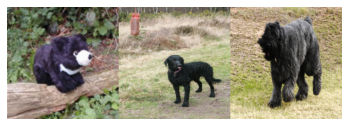

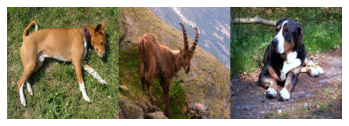

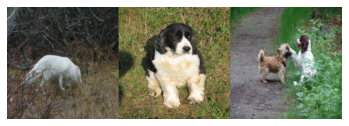

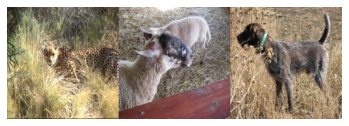

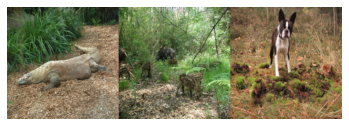

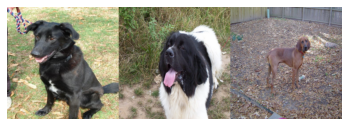

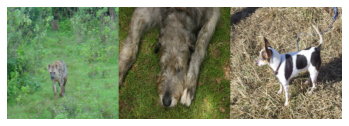

In [146]:
#msg = 123
#images = random.sample(msg2img[msg], 60)
#images = msg2img[msg]

"""
for msg_idx in range(10):
    images = msg2img[cnt_msg.most_common(20)[msg_idx][0]]
    for img_idx in range(0, 10):
        plt.axis('off')
        v = images[img_idx].permute(1, 2, 0)
        plt.imshow(v)
        plt.show()
        #plt.savefig(f"/private/home/rdessi/img")

        plt.imsave(f"/private/home/rdessi/img/msg_{msg_idx+1}/img_{img_idx}.png", v.numpy())
        
"""
msg = 1697
#images = random.sample(msg2img[msg], 60)
images = msg2img[msg]

for img_idx in range(0, 20, 3):
    plt.axis('off')
    v = torch.cat([
        images[img_idx].permute(1, 2, 0),
        images[img_idx+1].permute(1, 2, 0),
        images[img_idx+2].permute(1, 2, 0),
    ], dim=1)
    plt.imshow(v)
    plt.show()
